# ViEWS 3 ensembles: future predictions

UK FCDO Fatalities project, pgm level

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList, produced by the notebook fatal_pgm_compute_ensemble in this repository. 

The notebook draws on the following .py script files in this repository:

Ensembling.py

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *

# Mapper
import geopandas as gpd

from views_dataviz.map import mapper, utils
from views_dataviz import color
from views_dataviz.map.presets import ViewsMap

import sqlalchemy as sa
from ingester3.config import source_db_path

import sqlalchemy as sa
from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial
from genetic2 import *

from pathlib import Path

# Predicting fatalities scripts
from HurdleRegression import *
import Ensembling
from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated
import FetchData

In [148]:
# Common parameters:

dev_id = 'Fatalities001'
run_id = 'Fatalities001' 
EndOfHistory = 507
prod_id = 'Prod_' + str(EndOfHistory) + '_v1' # Change to run_id + str(EndOfHistory) + 'v1'
get_future = True

level = 'pgm'

depvar = "ln_ged_sb_dep"

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

Mydropbox = '/Users/jim/Dropbox (ViEWS)/ViEWS/'

overleafpath = '/Users/jim/Dropbox (ViEWS)/Apps/Overleaf/ViEWS predicting fatalities/'



In [149]:
gitname = 'EnsembleMetaData_pgm_' + dev_id + '.csv'
EnsembleMetaData = pd.read_csv(gitname)
ModelList = EnsembleMetaData.to_dict('records')
i = 0
for model in ModelList:
    print(i, model['modelname'])
    i = i + 1

0 fat_jed_hh_baseline_lgbm
1 fat_jed_hh_conflictlong_lgbm
2 fat_jed_hh_conflictlong_hurdle_lgbm
3 fat_jed_hh_drought_hurdle_lgbm
4 fat_jed_hh_drought_lgbm
5 fat_jed_hh_natsoc_hurdle_lgbm
6 fat_jed_hh_natsoc_lgbm
7 fat_jed_hh_broad_hurdle_lgbm
8 fat_jed_hh_broad_lgbm
9 fat_jed_pv_conf_hist_pgm
10 fat_tree_lags_d_1_d_2_hur_36
11 fat_sptime_dist_nu1_10_001_hur_36


# Retrieve and calibrate predictions and data

In [157]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = Ensembling.RetrieveStoredPredictions_pgm(ModelList, steps, EndOfHistory, run_id, level, False)

0 fat_jed_hh_baseline_lgbm
pr_45_pgm_fat_jed_hh_baseline_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_baseline_lgbm_test.parquet
1 fat_jed_hh_conflictlong_lgbm
pr_45_pgm_fat_jed_hh_conflictlong_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_conflictlong_lgbm_test.parquet
2 fat_jed_hh_conflictlong_hurdle_lgbm
pr_45_pgm_fat_jed_hh_conflictlong_hurdle_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_conflictlong_hurdle_lgbm_test.parquet
3 fat_jed_hh_drought_hurdle_lgbm
pr_45_pgm_fat_jed_hh_drought_hurdle_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_drought_hurdle_lgbm_test.parquet
4 fat_jed_hh_drought_lgbm
pr_45_pgm_fat_jed_hh_drought_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_drought_lgbm_test.parquet
5 fat_jed_hh_natsoc_hurdle_lgbm
pr_45_pgm_fat_jed_hh_natsoc_hurdle_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_natsoc_hurdle_lgbm_test.parquet
6 fat_jed_hh_natsoc_lgbm
pr_45_pgm_fat_jed_hh_natsoc_lgbm_calib.parquet
pr_45_pgm_fat_jed_hh_natsoc_lgbm_test.parquet
7 fat_jed_hh_broad_hurdle_lgbm
pr_45_pgm_fat_jed_hh_broad_hurdl

In [47]:
Datasets = FetchData.FetchData_pgm(dev_id)

Fetching data using querysets; returns as list of dictionaries containing datasets
 .    baseline: A dataset with 8 columns, with data between t = 1 and 852; 13110 units.
 .    conflictlong: A dataset with 19 columns, with data between t = 1 and 852; 13110 units.
 .    escwa_drought: A dataset with 29 columns, with data between t = 1 and 852; 13110 units.
 .    natsoc: A dataset with 24 columns, with data between t = 1 and 852; 13110 units.
 .    broad: A dataset with 23 columns, with data between t = 1 and 852; 13110 units.
 .    paola_conf_hist: A dataset with 30 columns, with data between t = 1 and 852; 13110 units.
 .    conf_treelag: A dataset with 8 columns, with data between t = 1 and 852; 13110 units.
 .    conf_sptime_dist: A dataset with 11 columns, with data between t = 1 and 852; 13110 units.


In [127]:
for model in ModelList:
    print(model['modelname'])
    print(model['algorithm'])

fat_jed_hh_baseline_lgbm
LGBMRegressor(n_estimators=200)
fat_jed_hh_conflictlong_lgbm
LGBMRegressor(n_estimators=200)
fat_jed_hh_conflictlong_hurdle_lgbm
HurdleRegression(clf_name='LGBMClassifier', clf_params={'n_estimators': 200},
                 reg_name='LGBMRegressor', reg_params={'n_estimators': 200})
fat_jed_hh_drought_hurdle_lgbm
HurdleRegression(clf_name='LGBMClassifier', clf_params={'n_estimators': 200},
                 reg_name='LGBMRegressor', reg_params={'n_estimators': 200})
fat_jed_hh_drought_lgbm
LGBMRegressor(n_estimators=200)
fat_jed_hh_natsoc_hurdle_lgbm
HurdleRegression(clf_name='LGBMClassifier', clf_params={'n_estimators': 200},
                 reg_name='LGBMRegressor', reg_params={'n_estimators': 200})
fat_jed_hh_natsoc_lgbm
LGBMRegressor(n_estimators=200)
fat_jed_hh_broad_hurdle_lgbm
HurdleRegression(clf_name='LGBMClassifier', clf_params={'n_estimators': 200},
                 reg_name='LGBMRegressor', reg_params={'n_estimators': 200})
fat_jed_hh_broad_lgbm
LGB

In [150]:
calibrate_const_models=False

from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult

RewritePredictions = True # Set this to True to rewrite predictions even if they exist

def RetrainAndPredict(modelname):
    force_retrain = False
    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = FetchData.get_training_data(Datasets,ModelList,modelname),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "JED",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + run_id)
for model in ModelList:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
#    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    print(i, model['modelname'])

    ct = datetime.now()
    print('Trying to retrieve non-calibrated predictions', ct)
    if RewritePredictions:
        print(model['predstorename_ncal'])
        model['future_df_noncalibrated'] = RetrainAndPredict(model['modelname'])
    else:
        try:
            model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
            print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

        except KeyError:
            print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

    # Calibrating and storing   
    # Storing non-calibrated
        
#    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    print(i, model['modelname'])

    ct = datetime.now()
    print('Trying to retrieve non-calibrated predictions', ct)
    if RewritePredictions:
        model['future_df_noncalibrated'] = RetrainAndPredict(model['modelname'])
    else:
        try:
            model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
            print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

        except KeyError:
            print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

    # Calibrating and storing   
    # Storing non-calibrated
    
#    print('before store',model['future_df_noncalibrated'].index.names)
        
    model['future_df_noncalibrated'].forecasts.set_run(run_id)
    model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
    
#    print('after store',model['future_df_noncalibrated'].index.names)
    
    if calibrate_const_models:
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
            
        model['future_df_calibrated']['step_combined']=cal_pg_c(model['future_df_calibrated'],cm_predictions_future,'step_combined',df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)    
        # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    i = i + 1

print('All done')
        

Computing predictions, production run Prod_507_v1, development run Fatalities001
0 fat_jed_hh_baseline_lgbm
Trying to retrieve non-calibrated predictions 2022-05-30 11:33:20.827925
pgm_fat_jed_hh_baseline_lgbm_f507
Future 2022-05-30 11:33:20.876052
 * == Performing a run: "fat_jed_hh_baseline_lgbm_future" == * 
Model object named "fat_jed_hh_baseline_lgbm_future" with equivalent metadata already exists.
Fetching "fat_jed_hh_baseline_lgbm_future" from storage
0 fat_jed_hh_baseline_lgbm
Trying to retrieve non-calibrated predictions 2022-05-30 11:33:56.994226
Future 2022-05-30 11:33:57.036210
 * == Performing a run: "fat_jed_hh_baseline_lgbm_future" == * 
Model object named "fat_jed_hh_baseline_lgbm_future" with equivalent metadata already exists.
Fetching "fat_jed_hh_baseline_lgbm_future" from storage
1 fat_jed_hh_conflictlong_lgbm
Trying to retrieve non-calibrated predictions 2022-05-30 11:34:34.251289
pgm_fat_jed_hh_conflictlong_lgbm_f507
Future 2022-05-30 11:34:34.287591
 * == Perform

In [151]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'ensemble_cm_calib',
    'algorithm':            [],
    'depvar':               depvar,
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)



In [152]:
cm_ensemble=ViewsMetadata().with_name('cm_genetic_ensemble_f'+str(EndOfHistory)).fetch()

In [153]:
calib_run_id=int(cm_ensemble['runs_id'].values[0])

In [154]:
cm_predictions_calib = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_ensemble_genetic_calib')
cm_predictions_test = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_ensemble_genetic_test')
cm_predictions_future = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_genetic_ensemble_f'+str(EndOfHistory))

pr_33_cm_ensemble_genetic_calib.parquet
pr_33_cm_ensemble_genetic_test.parquet
pr_33_cm_genetic_ensemble_f507.parquet


In [155]:
stepcols=['step_pred_' + str(step) for step in steps]

In [158]:
n_models = len(ModelList)

targetcalib=ModelList[0]['predictions_calib_df'][depvar]
targettest=ModelList[0]['predictions_test_df'][depvar]

valscalib=ModelList[0]['predictions_calib_df'][stepcols].values.copy()
valstest=ModelList[0]['predictions_test_df'][stepcols].values.copy()
valsfuture=ModelList[0]['future_df_noncalibrated'].values.copy()

trimmed_calib=ModelList[0]['predictions_calib_df'][stepcols].copy()
index_calib=trimmed_calib.index
columns_calib=trimmed_calib.columns

trimmed_test=ModelList[0]['predictions_test_df'][stepcols].copy()
index_test=trimmed_test.index
columns_test=trimmed_test.columns

trimmed_future=ModelList[0]['future_df_noncalibrated'].copy()
index_future=trimmed_future.index
columns_future=trimmed_future.columns

for model in ModelList[1:]:
    print('adding',model['modelname'])

    valscalib+=model['predictions_calib_df'][stepcols].values.copy()
    valstest+=model['predictions_test_df'][stepcols].values.copy()
    valsfuture+=model['future_df_noncalibrated'].values.copy()

    valscalib/=n_models
    valstest/=n_models
    valsfuture/=n_models

    Ensemble['predictions_calib_df']=pd.DataFrame(data=valscalib, index=index_calib, columns=columns_calib)
    Ensemble['predictions_test_df']=pd.DataFrame(data=valstest, index=index_test, columns=columns_test)
    Ensemble['predictions_future_df']=pd.DataFrame(data=valsfuture, index=index_future, columns=columns_future)
    
df_pg_id_c_id=Ensembling.fetch_df_pg_id_c_id()
    
for col in stepcols:

    thisstep=int(''.join([''+str(f) for f in filter(str.isdigit, col)]))
    thismonth = EndOfHistory + thisstep

    Ensemble['predictions_calib_df'][col]=Ensembling.calibrate_pg_with_c(Ensemble['predictions_calib_df'],cm_predictions_calib,col,df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)

    Ensemble['predictions_test_df'][col]=Ensembling.calibrate_pg_with_c(Ensemble['predictions_test_df'],cm_predictions_test,col,df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)
    
future_calib=Ensembling.calibrate_pg_with_c(Ensemble['predictions_future_df'],cm_predictions_future,'step_combined',df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)    
    
Ensemble['predictions_future_df']['step_combined']=future_calib['step_combined']

adding fat_jed_hh_conflictlong_lgbm
adding fat_jed_hh_conflictlong_hurdle_lgbm
adding fat_jed_hh_drought_hurdle_lgbm
adding fat_jed_hh_drought_lgbm
adding fat_jed_hh_natsoc_hurdle_lgbm
adding fat_jed_hh_natsoc_lgbm
adding fat_jed_hh_broad_hurdle_lgbm
adding fat_jed_hh_broad_lgbm
adding fat_jed_pv_conf_hist_pgm
adding fat_tree_lags_d_1_d_2_hur_36
adding fat_sptime_dist_nu1_10_001_hur_36
 .    

In [159]:
Ensemble['predictions_calib_df'][depvar]=targetcalib
Ensemble['predictions_test_df'][depvar]=targettest

In [160]:
# Save ensemble predictions
predstore_calib = level +  '_' + Ensemble['modelname'] + '_calib'
Ensemble['predictions_calib_df'].forecasts.set_run(run_id)
Ensemble['predictions_calib_df'].forecasts.to_store(name=predstore_calib, overwrite = True)
predstore_test = level +  '_' + Ensemble['modelname'] + '_test'
Ensemble['predictions_test_df'].forecasts.set_run(run_id)
Ensemble['predictions_test_df'].forecasts.to_store(name=predstore_test, overwrite = True)
predstore_future = level +  '_' + Ensemble['modelname'] + '_f'+str(EndOfHistory)
Ensemble['predictions_future_df'].forecasts.set_run(run_id)
Ensemble['predictions_future_df'].forecasts.to_store(name=predstore_future, overwrite = True)

# Use ensemble predictions for test partition to create categorical predictions

In [60]:
ensemble_test_df=Ensemble['predictions_test_df'].copy()

In [61]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ln_ged_sb_dep,ged_gte_25,ged_multi
count,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,...,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000
mean,0.048460,0.050175,0.050129,0.050069,0.049780,0.059946,0.061269,0.069110,0.074190,0.065181,...,0.053682,0.054162,0.053358,0.051066,0.055259,0.053029,0.052785,0.016279,0.001187,0.010920
std,0.279730,0.280987,0.277936,0.290519,0.276473,0.349047,0.345778,0.422694,0.448508,0.391891,...,0.275788,0.282272,0.280178,0.276111,0.290054,0.293955,0.280265,0.207899,0.034433,0.130805
min,-0.020138,-0.127007,-0.002590,-0.121167,-0.097833,-0.000500,-0.000435,-0.004704,-0.013511,-0.007174,...,-0.133681,-0.005615,-0.006883,-0.013513,-0.390458,-0.014770,-0.013674,0.000000,0.000000,0.000000
25%,0.000075,0.000106,0.000135,0.000143,0.000182,0.000202,0.000218,0.000259,0.000295,0.000282,...,0.000576,0.000558,0.000563,0.000622,0.000580,0.000614,0.000571,0.000000,0.000000,0.000000
50%,0.000430,0.000546,0.000625,0.000731,0.000841,0.000894,0.000961,0.001091,0.001205,0.001272,...,0.002033,0.002049,0.002026,0.002278,0.002167,0.002198,0.002038,0.000000,0.000000,0.000000
75%,0.002898,0.003392,0.003745,0.004117,0.004504,0.004938,0.005522,0.005884,0.006388,0.006558,...,0.009109,0.009278,0.009206,0.009563,0.009535,0.009273,0.009410,0.000000,0.000000,0.000000
max,7.269841,6.592434,7.232289,8.278019,7.849818,10.700899,9.918594,10.460919,10.240162,9.569431,...,7.613748,7.032987,6.759357,7.108057,7.265648,7.385541,7.027814,7.817223,1.000000,4.000000


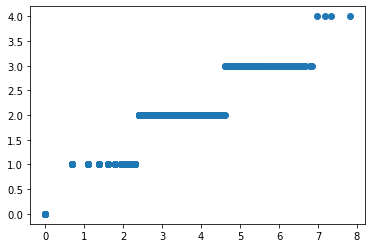

In [63]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [64]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    dichotomous_classifiers.append(dich_clf)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df['dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df.describe()

/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vecto

/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vecto

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_36135/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d

/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/opt/anaconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_36135/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,multi_0_step_35_logit,multi_1_step_35_logit,multi_2_step_35_logit,multi_3_step_35_logit,multi_4_step_35_logit,multi_0_step_36_logit,multi_1_step_36_logit,multi_2_step_36_logit,multi_3_step_36_logit,multi_4_step_36_logit
count,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,...,629280.000000,629280.000000,629280.000000,629280.000000,6.292800e+05,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000
mean,0.048460,0.050175,0.050129,0.050069,0.049780,0.059946,0.061269,0.069110,0.074190,0.065181,...,0.991996,0.005320,0.002458,0.000219,6.354401e-06,0.991996,0.005320,0.002458,0.000219,0.000006
std,0.279730,0.280987,0.277936,0.290519,0.276473,0.349047,0.345778,0.422694,0.448508,0.391891,...,0.033572,0.017600,0.013476,0.002643,1.442169e-04,0.032936,0.017525,0.012973,0.002653,0.000125
min,-0.020138,-0.127007,-0.002590,-0.121167,-0.097833,-0.000500,-0.000435,-0.004704,-0.013511,-0.007174,...,0.004204,0.003765,0.001440,0.000070,6.914340e-07,0.003722,0.003731,0.001451,0.000072,0.000001
25%,0.000075,0.000106,0.000135,0.000143,0.000182,0.000202,0.000218,0.000259,0.000295,0.000282,...,0.994545,0.003843,0.001474,0.000072,7.143612e-07,0.994561,0.003808,0.001484,0.000074,0.000001
50%,0.000430,0.000546,0.000625,0.000731,0.000841,0.000894,0.000961,0.001091,0.001205,0.001272,...,0.994598,0.003851,0.001477,0.000072,7.167635e-07,0.994620,0.003816,0.001488,0.000075,0.000001
75%,0.002898,0.003392,0.003745,0.004117,0.004504,0.004938,0.005522,0.005884,0.006388,0.006558,...,0.994610,0.003888,0.001493,0.000073,7.275963e-07,0.994632,0.003857,0.001505,0.000076,0.000001
max,7.269841,6.592434,7.232289,8.278019,7.849818,10.700899,9.918594,10.460919,10.240162,9.569431,...,0.994724,0.428390,0.438398,0.192478,2.016335e-02,0.994744,0.440211,0.431006,0.191948,0.013341


# Mapping future predictions

In [165]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

from views_dataviz import color
from views_dataviz.map import utils
from views_dataviz.map.presets import ViewsMap

import sqlalchemy as sa
from ingester3.config import source_db_path
from ingester3.Country import Country
from ingester3.extensions import *
from ingester3.ViewsMonth import ViewsMonth

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import numpy as np

class Mapper2:
    """
    `Map` takes basic properties and allows the user to consecutively add
    layers to the Map object. This makes it possible to prepare mapping
    "presets" at any level of layeredness that can be built on further.
    
    Mapper2 allows for the customizable addition of scaling to the map. 
    -re-add the code for labels later when i can test it

    Attributes
    ----------
    width: Integer value for width in inches.
    height: Integer value for height in inches.
    bbox: List for the bbox per [xmin, xmax, ymin, ymax].
    frame_on: Bool for whether to draw a frame around the map.
    title: Optional default title at matplotlib's default size.
    figure: Optional tuple of (fig, size) to use if you want to plot into an
        already existing fig and ax, rather than making a new one.
    """

    def __init__(
        self,
        width,
        height,
        bbox=None,
        cmap=None,
        frame_on=True,
        title="",  # Default title without customization. (?)
        figure=None,
    ):
        self.width = width
        self.height = height
        self.bbox = bbox  # xmin, xmax, ymin, ymax
        self.cmap = cmap
        if figure is None:
            self.fig, self.ax = plt.subplots(figsize=(self.width, self.height))
        else:
            self.fig, self.ax = figure
        self.texts = []
        self.ax.set_title(title)

        if frame_on:  # Remove axis ticks only.
            self.ax.tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
            )
        else:
            self.ax.axis("off")

        if bbox is not None:
            self.ax.set_xlim((self.bbox[0], self.bbox[1]))
            self.ax.set_ylim((self.bbox[2], self.bbox[3]))

    def add_layer(self, gdf, map_scale=False, map_dictionary=False, cmap=None, inform_colorbar=False, **kwargs):
        """Add a geopandas plot to a new layer.

        Parameters
        ----------
        gdf: Geopandas GeoDataFrame to plot.
        cmap: Optional matplotlib colormap object or string reference
            (e.g. "viridis").
        inform_colorbar: Set or overwrite colorbar with the current layer.
            Not applicable when `color` is supplied in the kwargs.
        map_scale: set a manual scale for the map. If missing defaults to the Remco procedure. 
        map_dictionary: set manual labels for the map. If missing defaults to the default labels.
        **kwargs: Geopandas `.plot` keyword arguments.
        """
        if "color" in kwargs:
            colormap = None
        else:
            colormap = self.cmap if cmap is None else cmap
            if inform_colorbar and "column" in kwargs:
                if hasattr(self, "cax"):
                    self.cax.remove()
                if "vmin" not in kwargs:
                    self.vmin = gdf[kwargs["column"]].min()
                else:
                    self.vmin = kwargs["vmin"]
                if "vmax" not in kwargs:
                    self.vmax = gdf[kwargs["column"]].max()
                else:
                    self.vmax = kwargs["vmax"]
        
        try: Mapper2.add_colorbar(self, colormap, min(map_scale), max(map_scale))
        except: Mapper2.add_colorbar(self, colormap, self.vmin, self.vmax)
        
        try:
            self.ax = gdf.plot(ax=self.ax, cmap=colormap, vmin=min(map_scale), vmax=max(map_scale), **kwargs)
        except: 
            self.ax = gdf.plot(ax=self.ax, cmap=colormap, **kwargs)

                
        return self
    
    def add_colorbar(
        self,
        cmap,
        vmin,
        vmax,
        location="right",
        size="5%",
        pad=0.1,
        alpha=1,
        labelsize=16,
        tickparams=None,
    ):
        """Add custom colorbar to Map.

        Needed since GeoPandas legend and plot axes do not align, see:
        https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html

        Parameters
        ----------
        cmap: Matplotlib colormap object or string reference (e.g. "viridis").
        vmin: Minimum value of range colorbar.
        vmax: Maximum value of range colorbar.
        location: String for location of colorbar: "top", "bottom", "left"
            or "right".
        size: Size in either string percentage or number of pixels.
        pad: Float for padding between the plot's frame and colorbar.
        alpha: Float for alpha to apply to colorbar.
        labelsize: Integer value for the text size of the ticklabels.
        tickparams: Dictionary containing value-label pairs. For example:
            {0.05: "5%", 0.1: "10%"}
        """
        norm = plt.Normalize(vmin, vmax)
        if isinstance(cmap, str):
            cmap = plt.get_cmap(cmap)
        cmap = color.force_alpha_colormap(cmap=cmap, alpha=alpha)
        scalar_to_rgba = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        divider = make_axes_locatable(self.ax)
        self.cax = divider.append_axes(location, size, pad)
        self.cax.tick_params(labelsize=labelsize)
        tickvalues = (
            list(tickparams.keys()) if tickparams is not None else None
        )
        self.cbar = plt.colorbar(
            scalar_to_rgba, cax=self.cax, ticks=tickvalues
        )
        if tickparams is not None:
            self.cbar.set_ticklabels(list(tickparams.values()))
        return self
    
    def save(
        self, path, dpi=200, **kwargs
    ):  # Just some defaults to reduce work.
        """Save Map figure to file.
        Parameters
        ----------
        path: String path, e.g. "./example.png".
        dpi: Integer dots per inch. Increase for higher resolution figures.
        **kwargs: Matplotlib `savefig` keyword arguments.
        """
        self.fig.savefig(path, dpi=dpi, bbox_inches="tight", **kwargs)
        plt.close(self.fig)
        

def vid2date(i):
    year=str(ViewsMonth(i).year)
    month=str(ViewsMonth(i).month)
    return year+'/'+month

#note the zip function occured earlier
standard_scale = [np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100),  np.log1p(300)]#, np.log1p(1000), np.log1p(3000),  np.log1p(10000)]
standard_scale_labels = ['0', '3','10', '30','100', '300']#, '1000', '3000', '10000']

small_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100),  np.log1p(300)]#, np.log1p(1000)]


small_scale_labels = ['0', '3','10', '30','100', '300']#, '1000']

small_scale_nolabels = ['', '','', '','', '', '']

In [185]:
# get pgm geometries
gdf_base = gpd.read_parquet('./geometry/pgm_geometry.parquet')

In [188]:
# get cm geometries
gdf_c = gpd.read_parquet('./geometry/cm_geometry.parquet')
gdf_c = gdf_c.to_crs(4326)

In [190]:
df_with_wanted_index=Datasets[0]['df']

FetchData.index_check(EnsembleList[0],df_with_wanted_index)

In [191]:
# Future prediction maps, predictions, rolling
#path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/'
stepstoplot=[3,5,8,12,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = Ensemble['predictions_future_df'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("priogrid_gid"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [192]:
path='/Users/jim/Work/ViEWS/ViEWS3/projects/predicting_fatalities'

In [193]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=0.7,facecolor='None')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

In [180]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[29.446846321370213, 50.987309710685814, 1.1561557161401845, 18.29970129951559], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=m.fig
        fontdict={'fontsize':20}
        figure.text(0.4,0.45,'ETHIOPIA',fontdict=fontdict,color='black')
        figure.text(0.2,0.7,'SUDAN',fontdict=fontdict,color='black')
        figure.text(0.15,0.35,'S. SUDAN',fontdict=fontdict,color='black')
        figure.text(0.65,0.5,'SOMALIA',fontdict=fontdict,color='black')
        figure.text(0.35,0.25,'KENYA',fontdict=fontdict,color='black')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_Ethiopia_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

In [181]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-2.3019466946294584, 20.374695512438592, 1.103974761908613, 16.794164972712068], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=m.fig
        fontdict={'fontsize':20}
        figure.text(0.4,0.45,'NIGERIA',fontdict=fontdict,color='black')
        figure.text(0.4,0.7,'NIGER',fontdict=fontdict,color='black')
        figure.text(0.5,0.35,'CAMEROON',fontdict=fontdict,color='black')
        figure.text(0.7,0.60,'CHAD',fontdict=fontdict,color='black')
        figure.text(0.7,0.4,'C.A.R.',fontdict=fontdict,color='black')
        figure.text(0.15,0.60,'B. FASO',fontdict=fontdict,color='black')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_Nigeria_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

# Changes to 3- and 6-month forecasts, and since last actual observation


In [144]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['predictions_future_df'].copy()

df_then=ViewsMetadata().with_name('ensemble_cm_calib_f'+str(EndOfHistory-3)).fetch()

try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals

df_lastobserved = Datasets[0]['df']

pr_45_pgm_ensemble_cm_calib_f503.parquet


In [146]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [147]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
]
engine = sa.create_engine(source_db_path)
#predictors_df = data_vdem_short.loc[EndOfHistory]
#predictors_df_3m = data_vdem_short.loc[EndOfHistory-3]

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
#    # Surrogate model change
#    for sm in SurrogateModelList:
#        if sm['Step'] == s['Step']:
#            s['sdf'] = predictors_df[sm['Columns']]
#            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
#            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
#            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
#            print(sm['Step'],sm['Predcolname'])
#            dfcolname = sm['Predcolname'][:-2] + '_ch3m'
#            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gpd.GeoDataFrame.from_postgis(
        "SELECT id as priogrid_gid, in_africa, in_me, geom FROM prod.priogrid", 
        engine, 
        geom_col='geom'
    )
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("priogrid_gid"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    
StepsForward[0]['gdf'].describe()

,Now,Then,ln_ged_sum,Change_in_prediction,Change_since_last_observed
count,1.311000e+04,13110.000000,13110.000000,13110.000000,13110.000000
mean,5.165435e-02,0.045541,0.034437,0.006114,0.017217
std,2.349658e-01,0.220613,0.245615,0.134541,0.194396
min,8.551403e-08,0.000003,0.000000,-2.691009,-3.507328
25%,1.550304e-04,0.000200,0.000000,-0.000300,0.000137
50%,6.658813e-04,0.000599,0.000000,0.000004,0.000599
75%,4.735184e-03,0.003526,0.000000,0.000770,0.003909
max,3.504299e+00,4.136319,6.163315,2.845436,2.707925


In [169]:
tickvalues = np.array([-80,-50,-20,0,20,50,100,200,500])
print(tickvalues)
ticklabels=[str(tv) for tv in tickvalues]
tickvalues = np.log((100+tickvalues)/100)
print(tickvalues)

[-80 -50 -20   0  20  50 100 200 500]
[-1.60943791 -0.69314718 -0.22314355  0.          0.18232156  0.40546511
  0.69314718  1.09861229  1.79175947]


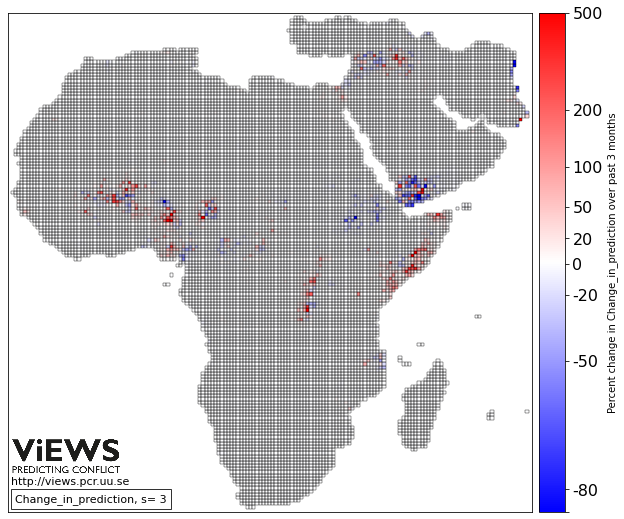

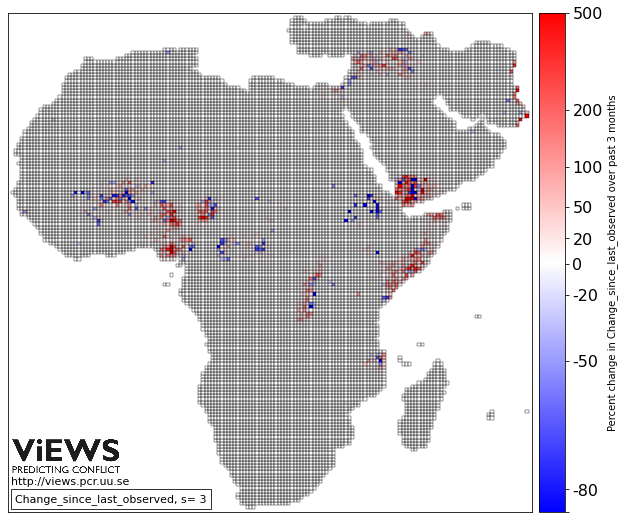

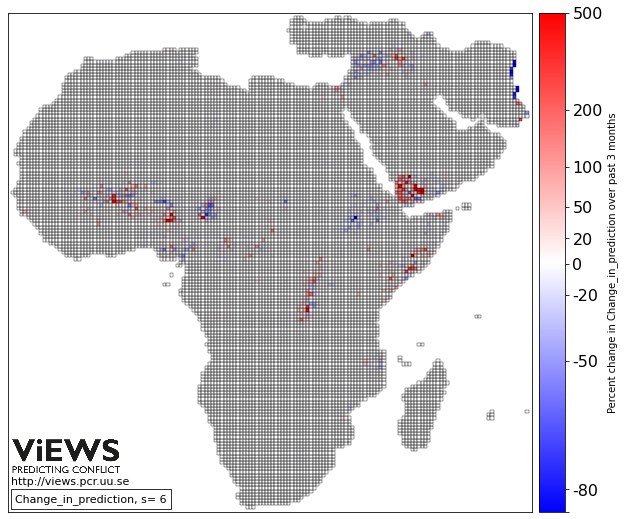

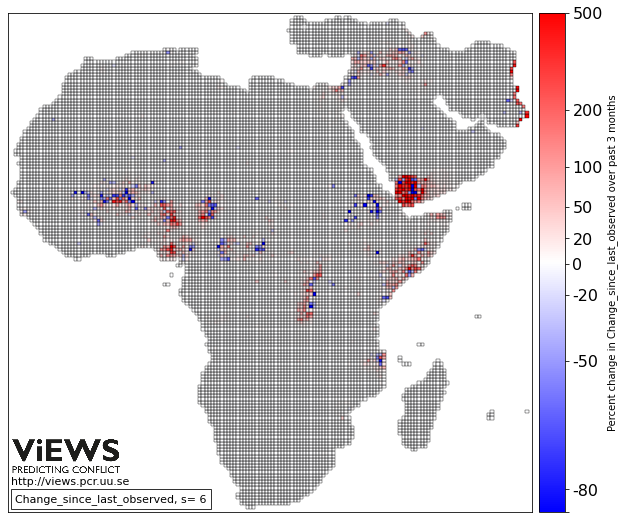

In [170]:
delta = 3

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(506,507) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
for s in StepsForward:
    for column in ['Change_in_prediction','Change_since_last_observed']:
        titlestring=''
        plot = ViewsMap(
            width=10,
            label=f"{column}, s= {s['Step']}",
            title="",
            scale=None,
            bbox=bbox
        ).add_layer(
            s['gdf'],
            edgecolor="black",
            linewidth=0.1,
            column=column,
        inform_colorbar=True,
        cmap=cmap,
        vmin=tickvalues[0],vmax=tickvalues[-1]
    )

        ax=plot.ax
        fg=s['gdf'].plot(ax=ax,edgecolor='black',linewidth=0.2,facecolor='None')
       # fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=plot.fig
        fontdict={'fontsize':20}
        fig=plot.fig

        plot.cbar.set_ticks(tickvalues)
        plot.cbar.set_ticklabels(ticklabels)
        if abs(delta)==1:
            mnth='month'
        else:
            mnth='months'
        plot.cbar.set_label(f'Percent change in {column} over past '+str(delta)+' '+mnth)

#        plot.save(overleafpath+'Figures/Future/'+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')